In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

In [3]:
def read_and_preprocess(file_path, event_code, target_date_str):
    df = pd.read_csv(file_path, header=1)
    
    df['Created Date'] = pd.to_datetime(df['Created Date'], dayfirst=True)
    df['Event'] = event_code

    target_date = pd.to_datetime(target_date_str, dayfirst=True)
    df['T_minus'] = (target_date - df['Created Date']).dt.days - 1 # excludes the target date

    # Filter out rows where T_minus is negative (i.e., created date is after the target date)
    df = df[df['T_minus'] >= 0]

    return df

def combine_datasets(*datasets):
    return pd.concat(datasets, ignore_index=True)

'''def plot_registrations_countdown(combined_data,tile):
    t_minus_registrations = combined_data.groupby('T_minus').size()
    plt.figure(figsize=(20, 6))
    plt.plot(t_minus_registrations.index, t_minus_registrations.values, marker='o', linestyle='-', color='b')
    plt.title(tile)
    plt.xlabel('Days Until Event (T-minus)')
    plt.ylabel('Number of Registrations')
    plt.grid(True)
    plt.tight_layout()
    plt.show()'''

def calculate_daily_registrations(combined_data):
    # Aggregate total registrations and calculate mean and standard deviation for Z-Score
    agg_operations = {
        'Total Registrations': ('Created Date', 'size'),
        'T_minus': ('T_minus', 'first')  # Assumes each date has a unique, correct T_minus value
    }
    daily_registrations = combined_data.groupby('Created Date').agg(**agg_operations).reset_index()
    
    # Calculate Z-Score
    daily_registrations['Z-Score'] = ((daily_registrations['Total Registrations'] - daily_registrations['Total Registrations'].mean()) 
                                      / daily_registrations['Total Registrations'].std())
    
    # Determine if advertisement should be done based on Z-Score
    daily_registrations['Advertisement'] = (daily_registrations['Z-Score'] > 2).astype(int)

    return daily_registrations
    

def prepare_for_forecasting_with_t_minus(daily_registrations):
    # Sort 'daily_registrations' by 'T_minus'
    daily_registrations_sorted = daily_registrations.sort_values(by='T_minus')
    
    # Find the min and max 'T_minus' values to create a complete series
    min_t_minus = daily_registrations_sorted['T_minus'].min()
    max_t_minus = daily_registrations_sorted['T_minus'].max()
    
    # Create a DataFrame representing every 'T_minus' day in the inclusive range
    complete_t_minus_range = pd.DataFrame(range(min_t_minus, max_t_minus + 1), columns=['T_minus'])
    
    # Merge with the actual registration data, ensuring every 'T_minus' day is represented
    complete_reg = pd.merge(complete_t_minus_range, daily_registrations_sorted, on='T_minus', how='left', sort=True)
    
    # Fill missing values for days without registrations with zeros
    complete_reg['Total Registrations'].fillna(0, inplace=True)
    complete_reg['Z-Score'].fillna(0, inplace=True)
    complete_reg['Advertisement'].fillna(0, inplace=True)
    
    # Set 'T_minus' as the DataFrame index
    complete_reg = complete_reg.set_index('T_minus')
    
    return complete_reg


def split_data_for_forecasting(complete_reg, split_ratio=0.8):
    complete_reg_sorted = complete_reg.sort_values(by='T_minus', ascending=True)
    
   # Determine the split point
    total_days = len(complete_reg_sorted)
    test_size = int(total_days * (1 - split_ratio))
    train_size = total_days - test_size

    train = complete_reg_sorted.iloc[test_size:]
    test = complete_reg_sorted.iloc[:test_size]

    # Extract the endogenous and exogenous variables for the training and testing sets
    train_endog = train['Total Registrations']
    train_exog = train[['Advertisement']]
    test_endog = test['Total Registrations']
    test_exog = test[['Advertisement']]

    return train_endog, train_exog, test_endog, test_exog

def auto_arima_forecasting(endog, exog):
    auto_model = auto_arima(endog, exogenous=exog, seasonal=True, m=7, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True)
    #print(auto_model.summary())
    return auto_model.order, auto_model.seasonal_order

def sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order):
    model = SARIMAX(train_endog, order=order, seasonal_order=seasonal_order, exog=train_exog)
    results = model.fit()
    #print(results.summary())
    forecast_results = results.get_forecast(steps=len(test_exog), exog=test_exog)
    return forecast_results.predicted_mean, forecast_results.conf_int()


def plot_forecast_vs_actuals(train, test, forecast_values, conf_int):
    # Calculate the number of days for the x-axis in reverse
    day_count_train = range(len(train))
    day_count_test = range(len(train) + len(test) - 1, len(train) - 1, -1)  # Reverse the range for test dataset

    # Reverse the 'Total Registrations' series
    train_registrations_reversed = train['Total Registrations'].iloc[::-1].values
    test_registrations_reversed = test['Total Registrations'].iloc[::-1].values
    forecast_values_reversed = forecast_values[::-1]
    conf_int_reversed_lower = conf_int.iloc[::-1, 0]
    conf_int_reversed_upper = conf_int.iloc[::-1, 1]

    # Plotting
    plt.figure(figsize=(30, 6))

    # Plot the observed values with reversed day count as x-axis
    plt.plot(list(day_count_train), train_registrations_reversed, label='Train', color='blue')
    plt.plot(list(day_count_test), test_registrations_reversed, label='Test', color='green')

    # Plot the forecasted values
    plt.plot(list(day_count_test), forecast_values_reversed, label='Forecast', color='red')

    # Plot the confidence interval
    plt.fill_between(list(day_count_test), conf_int_reversed_lower, conf_int_reversed_upper, color='pink', alpha=0.3)

    # Reverse the x-axis tick labels and remove '.0'
    x_ticks = plt.gca().get_xticks()
    plt.gca().set_xticklabels([int(x) for x in reversed(x_ticks)])

    # Set labels and title
    plt.xlabel('Day Count')
    plt.ylabel('Total Registrations')
    plt.title('SARIMAX Model Forecast vs Actuals')

    plt.legend()
    plt.show()



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=2565.214, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2789.977, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2709.926, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2787.977, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=2563.215, Time=0.73 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,1,2)(1,0

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported

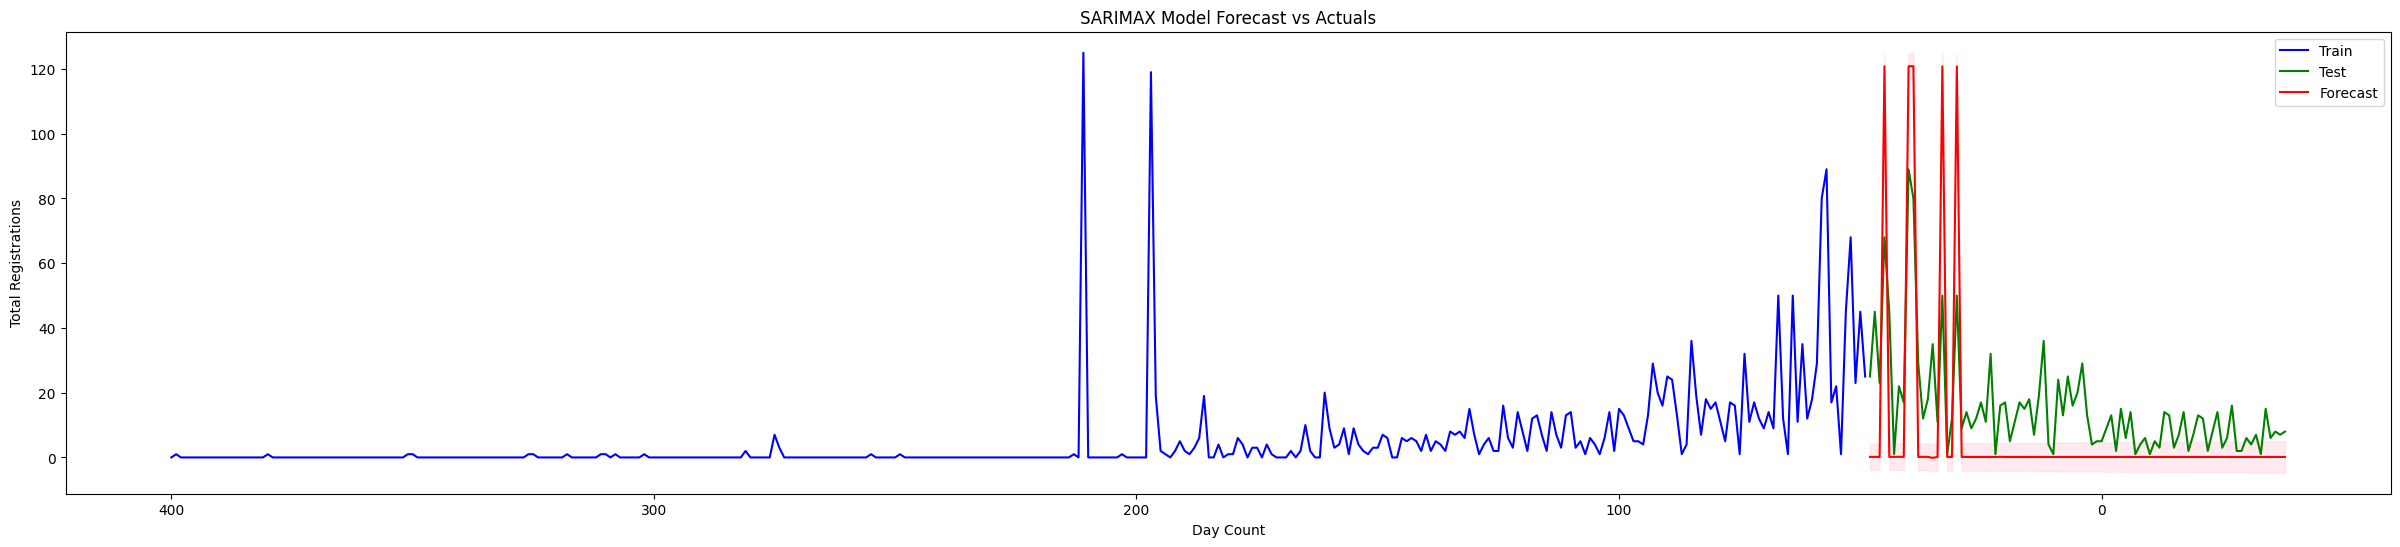

In [4]:
# IT Managers SARIMAX

# D19 & D21
d19 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\D19.csv", 'D19', '19/11/2019')
d21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\D21.csv", 'D21', '09/12/2021')

# Combine datasets
combined_it_managers = combine_datasets(d19, d21)

# Proceed with analysis and plotting
#plot_registrations_countdown(combined_it_managers, 'Registrations Countdown to IT Managers Conference')
daily_registrations_it = calculate_daily_registrations(combined_it_managers)
complete_reg_it = prepare_for_forecasting_with_t_minus(daily_registrations_it)

# Split the data into training and testing sets
train_endog, train_exog, test_endog, test_exog = split_data_for_forecasting(complete_reg_it)

# Use Auto ARIMA to find the optimal SARIMAX parameters
order, seasonal_order = auto_arima_forecasting(train_endog, train_exog)

# Fit the SARIMAX model using the optimal parameters
forecast_values, conf_int = sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order)

test_df = test_exog.copy()
test_df['Total Registrations'] = test_endog.values

# Plot the forecast against actual values
plot_forecast_vs_actuals(complete_reg_it.iloc[:len(train_endog)], test_df, forecast_values, conf_int)


In [5]:
# Calculate RMSE and MAE for SARIMAX
rmse_sarimax = np.sqrt(mean_squared_error(test_endog, forecast_values))
mae_sarimax = mean_absolute_error(test_endog, forecast_values)

# Find the maximum value
max_value = test_endog.max()

# Calculate RMSE as a percentage of the max value
rmse_pct_sarimax = (rmse_sarimax / max_value) * 100

# Calculate MAE as a percentage of the max value
mae_pct_sarimax = (mae_sarimax / max_value) * 100

print(f"SARIMAX RMSE (IT): {rmse_sarimax:.2f},RMSE %: {rmse_pct_sarimax: .2f}%, MAE: {mae_sarimax:.2f}, MAE %: {mae_pct_sarimax: .2f}%")

SARIMAX RMSE (IT): 20.11,RMSE %:  22.59%, MAE: 14.42, MAE %:  16.21%


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=2301.407, Time=1.01 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=2316.956, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=2295.395, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=2294.732, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=2327.800, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=2302.744, Time=0.06 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=2296.680, Time=0.28 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=2296.676, Time=0.24 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=2295.257, Time=0.09 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=2306.571, Time=0.07 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=2296.668, Time=0.30 sec
 ARIMA(0,0,2)(0,0,1)[7] intercept   : AIC=2296.674, Time=0.17 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=2294.858, Time=0.15 sec
 ARIMA(1,0,2)(0,0,1)[7] intercept   : 

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported

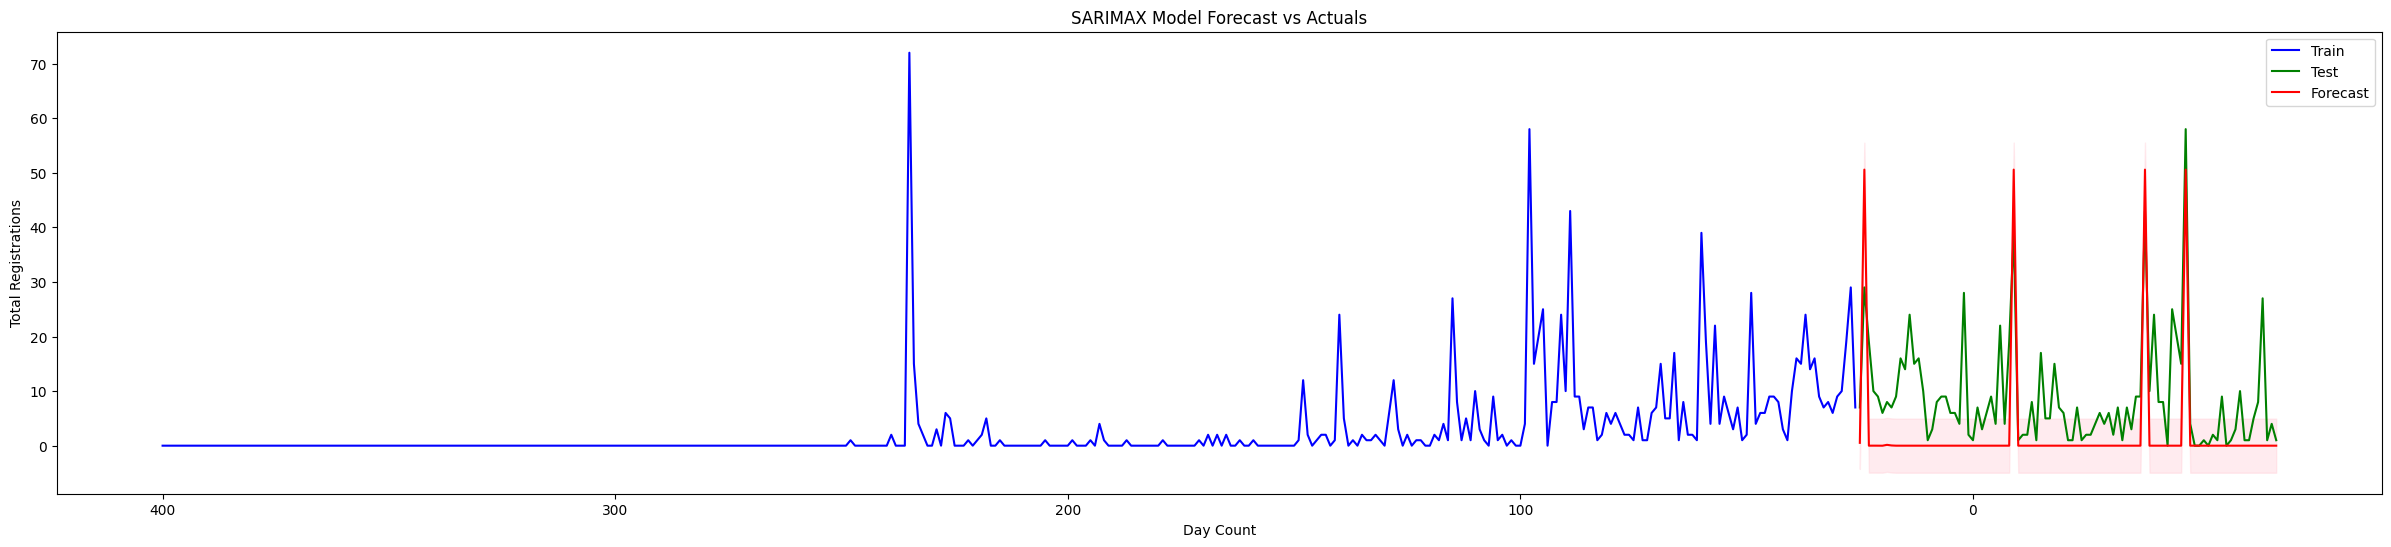

In [6]:
# Property Managers SARIMAX:
# GP21 and NP21
gp21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\GP21.csv", 'GP21', '22/04/2021')
np21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\NP21.csv", 'NP21', '09/11/2021')

# Combine datasets 
combined_property_managers = combine_datasets(gp21, np21)

# Proceed with analysis and plotting
#plot_registrations_countdown(combined_property_managers, 'Registrations Countdown to Property Managers Conference')
daily_registrations_prop = calculate_daily_registrations(combined_property_managers)
complete_reg_prop = prepare_for_forecasting_with_t_minus(daily_registrations_prop)

# Split the data into training and testing sets
train_endog, train_exog, test_endog, test_exog = split_data_for_forecasting(complete_reg_prop)

# Use Auto ARIMA to find the optimal SARIMAX parameters
order, seasonal_order = auto_arima_forecasting(train_endog, train_exog)

# Fit the SARIMAX model using the optimal parameters
forecast_values, conf_int = sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order)

test_df = test_exog.copy()
test_df['Total Registrations'] = test_endog.values

# Plot the forecast against actual values
plot_forecast_vs_actuals(complete_reg_prop.iloc[:len(train_endog)], test_df, forecast_values, conf_int)


In [7]:
# Calculate RMSE and MAE for SARIMAX
rmse_sarimax = np.sqrt(mean_squared_error(test_endog, forecast_values))
mae_sarimax = mean_absolute_error(test_endog, forecast_values)

# Find the maximum value
max_value = test_endog.max()

# Calculate RMSE as a percentage of the max value
rmse_pct_sarimax = (rmse_sarimax / max_value) * 100

# Calculate MAE as a percentage of the max value
mae_pct_sarimax = (mae_sarimax / max_value) * 100

print(f"SARIMAX RMSE (Property): {rmse_sarimax:.2f},RMSE %: {rmse_pct_sarimax: .2f}%, MAE: {mae_sarimax:.2f}, MAE %: {mae_pct_sarimax: .2f}%")

SARIMAX RMSE Property): 10.14,RMSE %:  17.48%, MAE: 7.51, MAE %:  12.95%


In [ ]:
# Education Managers SARIMAX
# SRM22 and SRM23
srm22 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\SRM22.csv", 'SRM22', '15/06/2022')
srm23 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\SRM23.csv", 'SRM23', '08/06/2023')

# Combine datasets
combined_ed_managers = combine_datasets(srm22, srm23)

# Proceed with analysis and plotting
#plot_registrations_countdown(combined_ed_managers, 'Registrations Countdown to Education Managers Conference')
daily_registrations_ed = calculate_daily_registrations(combined_ed_managers)
complete_reg_ed = prepare_for_forecasting_with_t_minus(daily_registrations_ed)

# Split the data into training and testing sets
train_endog, train_exog, test_endog, test_exog = split_data_for_forecasting(complete_reg_ed)

# Use Auto ARIMA to find the optimal SARIMAX parameters
order, seasonal_order = auto_arima_forecasting(train_endog, train_exog)

# Fit the SARIMAX model using the optimal parameters
forecast_values, conf_int = sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order)

test_df = test_exog.copy()
test_df['Total Registrations'] = test_endog.values

# Plot the forecast against actual values
plot_forecast_vs_actuals(complete_reg_ed.iloc[:len(train_endog)], test_df, forecast_values, conf_int)


In [8]:
# Calculate RMSE and MAE for SARIMAX
rmse_sarimax = np.sqrt(mean_squared_error(test_endog, forecast_values))
mae_sarimax = mean_absolute_error(test_endog, forecast_values)

# Find the maximum value
max_value = test_endog.max()

# Calculate RMSE as a percentage of the max value
rmse_pct_sarimax = (rmse_sarimax / max_value) * 100

# Calculate MAE as a percentage of the max value
mae_pct_sarimax = (mae_sarimax / max_value) * 100

print(f"SARIMAX RMSE (Education): {rmse_sarimax:.2f},RMSE %: {rmse_pct_sarimax: .2f}%, MAE: {mae_sarimax:.2f}, MAE %: {mae_pct_sarimax: .2f}%")

SARIMAX RMSE (Education): 10.14,RMSE %:  17.48%, MAE: 7.51, MAE %:  12.95%


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=521.710, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=524.029, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=519.714, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=523.705, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=523.706, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=524.998, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=522.036, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=inf, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 1.062 seconds


c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported

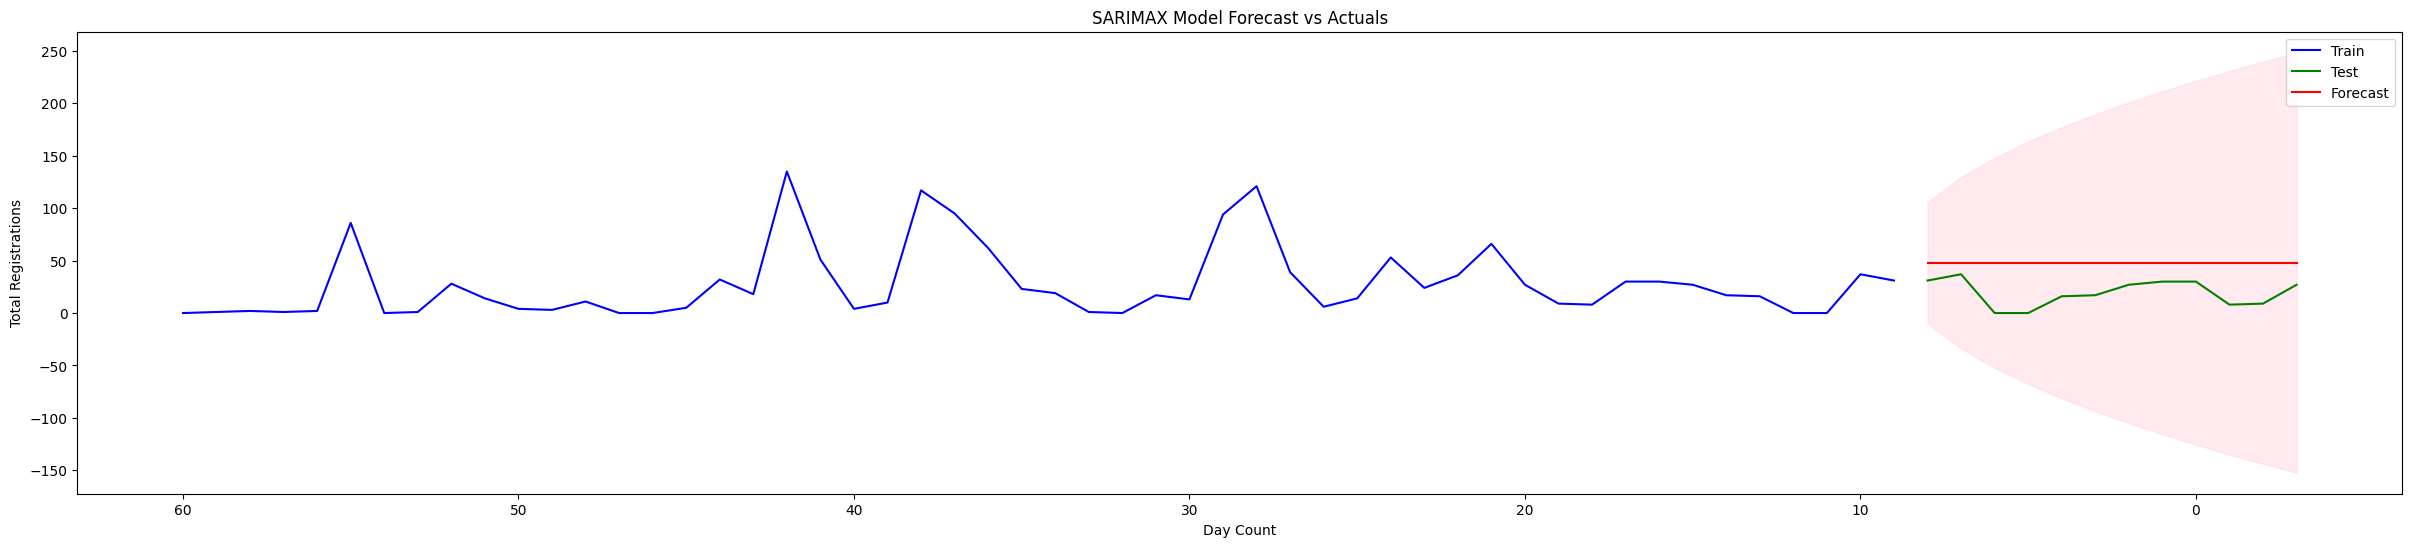

In [9]:
# Education Property Managers SARIMAX
# MSE21
mse21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\MSE21.csv", 'MSE21', '24/03/2021')

# Proceed with analysis and plotting
#plot_registrations_countdown(combined_ed_managers, 'Registrations Countdown to Education Managers Conference')
daily_registrations_edp = calculate_daily_registrations(mse21)
complete_reg_edp = prepare_for_forecasting_with_t_minus(daily_registrations_edp)

# Split the data into training and testing sets
train_endog, train_exog, test_endog, test_exog = split_data_for_forecasting(complete_reg_edp)

# Use Auto ARIMA to find the optimal SARIMAX parameters
order, seasonal_order = auto_arima_forecasting(train_endog, train_exog)

# Fit the SARIMAX model using the optimal parameters
forecast_values, conf_int = sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order)

test_df = test_exog.copy()
test_df['Total Registrations'] = test_endog.values

# Plot the forecast against actual values
plot_forecast_vs_actuals(complete_reg_edp.iloc[:len(train_endog)], test_df, forecast_values, conf_int)


In [10]:
# Calculate RMSE and MAE for SARIMAX
rmse_sarimax = np.sqrt(mean_squared_error(test_endog, forecast_values))
mae_sarimax = mean_absolute_error(test_endog, forecast_values)

# Find the maximum value
max_value = test_endog.max()

# Calculate RMSE as a percentage of the max value
rmse_pct_sarimax = (rmse_sarimax / max_value) * 100

# Calculate MAE as a percentage of the max value
mae_pct_sarimax = (mae_sarimax / max_value) * 100

print(f"SARIMAX RMSE (Education Property): {rmse_sarimax:.2f},RMSE %: {rmse_pct_sarimax: .2f}%, MAE: {mae_sarimax:.2f}, MAE %: {mae_pct_sarimax: .2f}%")

SARIMAX RMSE (Education Property): 31.16,RMSE %:  84.23%, MAE: 28.67, MAE %:  77.48%


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=4900.143, Time=1.51 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5220.649, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5115.078, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4895.952, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5218.655, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=4895.144, Time=0.15 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=4895.857, Time=0.37 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=4897.698, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=4893.507, Time=0.25 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=4894.325, Time=0.68 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=4894.392, Time=0.47 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=4896.249, Time=0.66 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=5113.380, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=4892.530, Time=0.52 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported

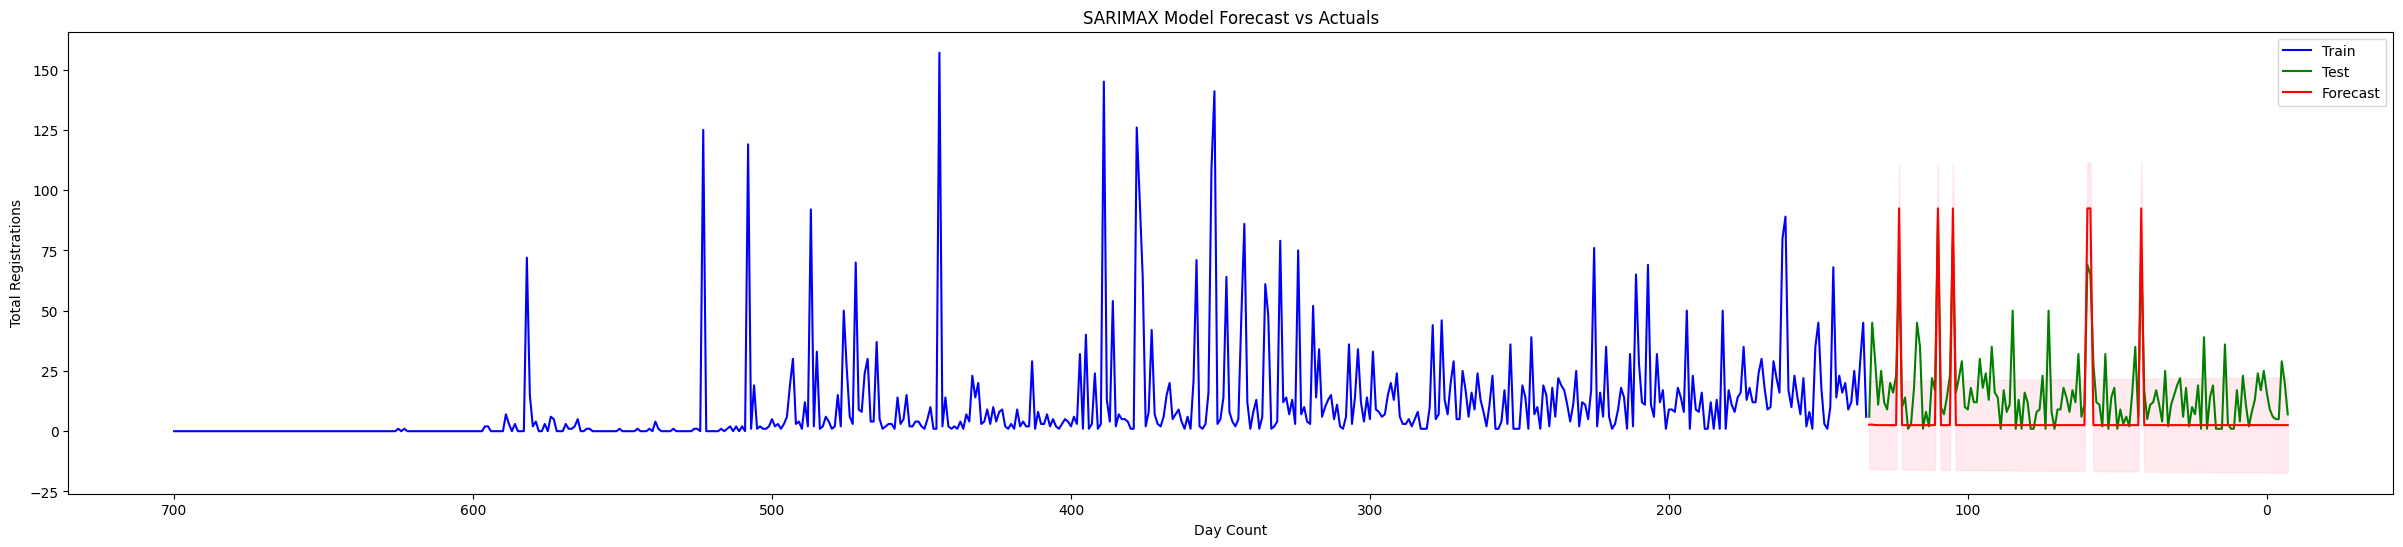

In [11]:
# All datasets
srm22 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\SRM22.csv", 'SRM22', '15/06/2022')
srm23 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\SRM23.csv", 'SRM23', '08/06/2023')
gp21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\GP21.csv", 'GP21', '22/04/2021')
np21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\NP21.csv", 'NP21', '09/11/2021')
d19 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\D19.csv", 'D19', '19/11/2019')
d21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\D21.csv", 'D21', '09/12/2021')
mse21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\MSE21.csv", 'MSE21', '24/03/2021')

# Combine datasets
combined = combine_datasets(srm22, srm23,gp21,np21, d19,d21, mse21)

# Proceed with analysis and plotting
#plot_registrations_countdown(combined_ed_managers, 'Registrations Countdown to Education Managers Conference')
daily_registrations_all = calculate_daily_registrations(combined)
complete_reg_all = prepare_for_forecasting_with_t_minus(daily_registrations_all)

# Split the data into training and testing sets
train_endog, train_exog, test_endog, test_exog = split_data_for_forecasting(complete_reg_all)

# Use Auto ARIMA to find the optimal SARIMAX parameters
order, seasonal_order = auto_arima_forecasting(train_endog, train_exog)

# Fit the SARIMAX model using the optimal parameters
forecast_values, conf_int = sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order)

test_df = test_exog.copy()
test_df['Total Registrations'] = test_endog.values

# Plot the forecast against actual values
plot_forecast_vs_actuals(complete_reg_all.iloc[:len(train_endog)], test_df, forecast_values, conf_int)


In [12]:
# Calculate RMSE and MAE for SARIMAX
rmse_sarimax = np.sqrt(mean_squared_error(test_endog, forecast_values))
mae_sarimax = mean_absolute_error(test_endog, forecast_values)

# Find the maximum value
max_value = test_endog.max()

# Calculate RMSE as a percentage of the max value
rmse_pct_sarimax = (rmse_sarimax / max_value) * 100

# Calculate MAE as a percentage of the max value
mae_pct_sarimax = (mae_sarimax / max_value) * 100

print(f"SARIMAX RMSE (All): {rmse_sarimax:.2f},RMSE %: {rmse_pct_sarimax: .2f}%, MAE: {mae_sarimax:.2f}, MAE %: {mae_pct_sarimax: .2f}%")

SARIMAX RMSE (All): 15.84,RMSE %:  17.80%, MAE: 11.98, MAE %:  13.46%
